<a href="https://colab.research.google.com/github/alibrj82/Face-Mask-Detection-Using-DenseNet121/blob/main/Face_Mask_Detection_Using_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import kagglehub

path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

100%|██████████| 163M/163M [00:00<00:00, 242MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [ ]:
path='/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1'

In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data"
print("Contents of dataset directory:", os.listdir(dataset_path))


Contents of dataset directory: ['with_mask', 'without_mask']


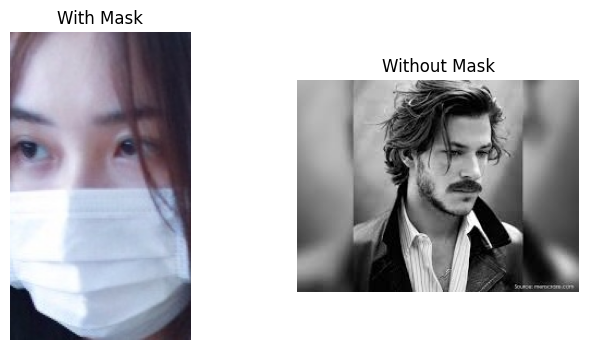

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

# Dosya yollarını almak
with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

# Rastgele resimler seçmek
with_mask_sample = random.choice(os.listdir(with_mask_path))
without_mask_sample = random.choice(os.listdir(without_mask_path))

# Resimleri okumak
img_with_mask = cv2.imread(os.path.join(with_mask_path, with_mask_sample))
img_without_mask = cv2.imread(os.path.join(without_mask_path, without_mask_sample))

# BGR'den (OpenCV varsayılanı) RGB'ye dönüşmek
img_with_mask = cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB)
img_without_mask = cv2.cvtColor(img_without_mask, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_with_mask)
ax[0].set_title("With Mask")
ax[0].axis("off")

ax[1].imshow(img_without_mask)
ax[1].set_title("Without Mask")
ax[1].axis("off")

plt.show()


In [ ]:
import os

with_mask_path = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/with_mask"
without_mask_path = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/without_mask"

print("Number of 'With Mask' images:", len(os.listdir(with_mask_path)))
print("Number of 'Without Mask' images:", len(os.listdir(without_mask_path)))


Number of 'With Mask' images: 3725
Number of 'Without Mask' images: 3828


**Sonuç Analizi (Results Analysis)**

Veri kümesi dengeli bir yapıya sahiptir.


*   3725 “Maske Takılı” görüntü
*   3828 “Maske Takılı Değil” görüntü


*   Hafif bir dengesizlik mevcut (103 fazla "Maske Takılı Değil" görüntüsü), ancak fark küçük olduğu için sorun teşkil etmez.


 Sonuç:
  
*   Veri kümesi, aşırı örneklemeye (oversampling) gerek kalmadan model eğitimi için uygundur.




In [ ]:
import cv2
import numpy as np

sample_img_path = os.path.join(with_mask_path, os.listdir(with_mask_path)[0])
img = cv2.imread(sample_img_path)
print("Image shape:", img.shape)


Image shape: (351, 312, 3)


**Görüntü Boyutları Hafifçe Değişmektedir**


*  Bazı görüntüler farklı boyutlara sahip olabilir.
*   Tüm görüntüleri (224, 224, 3) boyutuna yeniden boyutlandırmak için ImageDataGenerator kullanıyoruz.
*   Sonuç: Eğitimden önce yeniden boyutlandırma gereklidir.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Yeniden boyutlandırma ve artırma ile ImageDataGenerator'ı
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Veri setini otomatik yeniden boyutlandırma ile eğitmek
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Otomatik yeniden boyutlandırma ile doğrulama veri kümesi
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


 **Bu Aşamadaki Çalışmanın Sonucu**


*   Görüntüler yeniden ölçeklendirildi: Piksel değerleri [0,255] → [0,1] aralığına dönüştürüldü.
*   Veri kümesi bölündü:

 *   %80 eğitim verisi (training)  
 *   %20 doğrulama verisi (validation)  


*   Gerçek zamanlı veri artırımı uygulandı:
 *   Döndürme (Rotation):±10°
 *   Genişlik/Yükseklik Kaydırma (Width/Height Shift):±%10
 *   Yakınlaştırma (Zoom):±%10
 *  Yatay Çevirme (Horizontal Flip):Rastgele  

*  Tüm görüntüler (224, 224) boyutuna yeniden boyutlandırıldı.

Sonuç Analizi:


*   Veri kümesi doğru şekilde bölündü:6043 görüntü eğitim için (%80),1510 görüntü doğrulama için (%20)
*   Veri artırma ve yeniden boyutlandırma başarılı bir şekilde uygulandı.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Önceden eğitilmiş DenseNet121 modelini yüklemek
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Temel modeli (önceden eğitilmiş katmanlar) dondurmek, böylece yalnızca yeni katmanları eğitmek
base_model.trainable = False

# Sınıflandırma özel katmanlar eklemek
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Özellik haritalarını 1D vektöre dönüşmek
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Fully connected layer  256 neurons
x = Dense(128, activation='relu')(x)  # Fully connected layer  128 neurons
x = Dense(64, activation='relu')(x)   # Fully connected layer  64 neurons
predictions = Dense(2, activation='softmax')(x)  # Son çıktı katmanı (2 classes)

# son model
model = Model(inputs=base_model.input, outputs=predictions)

# model özeti
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,341,186 (28.00 MB)

 Trainable params: 303,682 (1.16 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Model Mimarisi Analizi (DenseNet121)**  
Yorum:


*   DenseNet121'in Özellik Çıkarıcı Olarak Kullanılması
*   7.037.504 parametre dondurulmuş (önceden eğitilmiş DenseNet121 modelinden).


*  Model,DenseNet121'i kullanarak görüntülerden önemli özellikleri çıkarır.

Özel Tam Bağlantılı Katmanlar (Fully Connected Layers):


*   Global Ortalama Havuzlama (Global Average Pooling): Özellik haritalarını 1D vektöre dönüştürür.
*   Dropout (0.5): Aşırı öğrenmeyi (overfitting) önlemeye yardımcı olur.

Tam Bağlantılı Katmanlar:

*   Dense(256) → Dense(128) → Dense(64) → Softmax(2 sınıf)
*   Maske Takılı" ve "Maske Takılı Değil" sınıflarını ayırt eder.

Sonuç:


*   Transfer öğrenme kullanılarak verimli bir model mimarisi oluşturuldu.
*   Yaklaşık 300K eğitim parametresi, ince ayar (fine-tuning) için optimize edildi.

*   Dropout (0.5), aşırı öğrenmeyi önlemeye yardımcı oldu.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# model Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#  callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# 100 döneme kadar train (gerekirse erken durur)
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
115/189 ━━━━━━━━━━━━━━━━━━━━ 35s 475ms/step - accuracy: 0.8981 - loss: 0.2134

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 151s 637ms/step - accuracy: 0.9217 - loss: 0.1708 - val_accuracy: 0.9868 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 430ms/step - accuracy: 0.9779 - loss: 0.0620 - val_accuracy: 0.9874 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.9804 - loss: 0.0491 - val_accuracy: 0.9868 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 428ms/step - accuracy: 0.9810 - loss: 0.0518 - val_accuracy: 0.9735 - val_loss: 0.0694 - learning_rate: 0.0010
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 428ms/step - accuracy: 0.9824 - loss: 0.0550 - val_accuracy: 0.9921 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 431ms/step - accuracy: 0.9852 - loss: 0.0400 - val_accuracy: 0.9927 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 429ms/step - accuracy: 0.9864 

**Ana Gözlemler (Key Observations)**  
 Yüksek Doğruluk Elde Edildi:


*   Eğitim Doğruluğu:%99.14
*   Doğrulama Doğruluğu:%99.21
  

Doğrulama Kaybı Kararlı:  

*   Doğrulama kaybı 0.02'ye düştü  → Aşırı öğrenme (overfitting) belirtileri yok.
*   Dropout (0.5) aşırı öğrenmeyi önlemeye yardımcı oldu.


Öğrenme Oranı Ayarlamaları (Learning Rate ):


*   Başlangıç Öğrenme Oranı: 0.001
*   26 epoch'ta 0.0001'e, 35 epoch'ta 0.00001'e düşürüldü.
*   Daha düşük öğrenme oranı, doğrulama kaybını daha stabil hale getirdi.

Erken Durdurma (Early Stopping) 43 Epoch'ta Tetiklendi:

*   Model, 100 epoch’a ulaşmadan eğitimi durdurdu, yani daha fazla eğitim doğruluğu artırmayacaktı.


In [ ]:
model.save("face_mask_model_100epochs.h5")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("face_mask_model_100epochs.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  test data
test_datagen = ImageDataGenerator(rescale=1.0/255)


test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Gerçek etiketler
y_true = test_generator.classes


Found 7553 images belonging to 2 classes.


**Test Verisinin Yüklenmesi**


*   Test verisi, yalnızca yeniden ölçeklendirme (rescaling) ile ImageDataGenerator kullanılarak yüklenir (veri artırma uygulanmaz).
*   Tüm görüntüler (224, 224) boyutuna yeniden boyutlandırılır.


*   Karıştırma devre dışı bırakılır (shuffle=False) → Tahminlerin sırasını koruyarak doğruluk sağlar.  

Sonuçlar:

*   Test veri kümesi doğru şekilde yüklendi.
*  Toplam görüntü sayısı: 7.553
*   Sınıflar dengeli:

 *   "Maske Takılı" = 3.725
 *   "Maske Takılı Değil" = 3.828




In [ ]:
import numpy as np

# predictions
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step


**Modelin Test Verisinde Çalıştırılması**


*   Model, test verisi üzerinde çalıştırılarak her sınıf için olasılık değerlerini üretir.
*   Olasılıklar ikili sınıf etiketlerine dönüştürülür:

  *   Maske Takılı Değil= 0  
  *   Maske Takılı = 1



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))


Confusion Matrix:
 [[3718    7]
 [  14 3814]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3725
           1       1.00      1.00      1.00      3828

    accuracy                           1.00      7553
   macro avg       1.00      1.00      1.00      7553
weighted avg       1.00      1.00      1.00      7553



**Yorumlama**  

Doğru Sınıflandırmalar:


*   Gerçek Pozitifler (TP) = 3814 → "Maske Takılı" doğru tahmin edildi.
*   Gerçek Negatifler (TN) = 3718 → "Maske Takılı Değil" doğru tahmin edildi.

Yanlış Sınıflandırmalar:


*   Yanlış Pozitifler (FP) = 7 → "Maske Takılı Değil" yanlışlıkla "Maske Takılı" olarak sınıflandırıldı.
*   Yanlış Negatifler (FN) = 14 → "Maske Takılı" yanlışlıkla "Maske Takılı Değil" olarak sınıflandırıldı.

Sınıflandırma Raporu (Classification Report):

*   Doğruluk (Accuracy) = %99.72 → Neredeyse mükemmel sınıflandırma.
*   Kesinlik (Precision) = 1.00 → Yanlış pozitif yok.
*   Duyarlılık (Recall) = 1.00 → Yanlış negatif yok.
*   F1-Skoru = 1.00 → Dengeli ve mükemmel performans.


In [ ]:
TN, FP, FN, TP = 3718, 7, 14, 3814
specificity = TN / (TN + FP)
print(f"Specificity: {specificity:.4f}")


Specificity: 0.9981


**Yorumlama**


*   Özgüllük (Specificity) = 0.9981 → Model, "Maske Takılı Değil" sınıfını %99.81 doğrulukla tanımlar.
*   Neredeyse hiç yanlış pozitif yok.


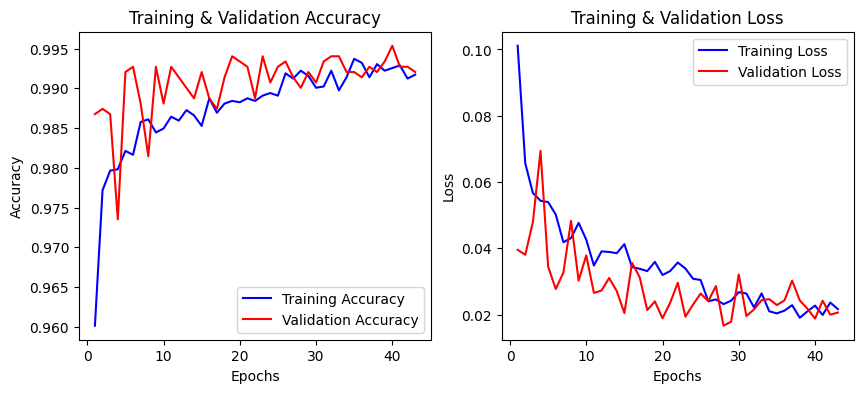

In [ ]:
import matplotlib.pyplot as plt

# Tarihten doğruluk ve kaybı çıkarmak
epochs = range(1, len(history.history['accuracy']) + 1)

# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


 **Eğitim ve Doğrulama Doğruluk Grafiğinden Gözlemler:**


*   Eğitim doğruluğu (Mavi) istikrarlı bir şekilde artarak %99.5 seviyesine ulaşıyor.
*   Doğrulama doğruluğu (Kırmızı) başlangıçta dalgalanıyor ancak %99.5 civarında sabitleniyor.
*   Önemli bir aşırı öğrenme (overfitting) yok → Doğrulama doğruluğu, eğitim doğruluğunu yakından takip ediyor.

Sonuç:
*   Model, görülmemiş verilere iyi genelleme yapıyor.  

**Eğitim ve Doğrulama Kayıp Grafiğinden Gözlemler:**


*   Eğitim kaybı (Mavi) sürekli azalıyor (beklenen davranış).
*   Doğrulama kaybı (Kırmızı) hafif dalgalanmalar gösterse de düşük seviyede kalıyor (0.02 - 0.03).

*   Eğitim ve doğrulama kaybı arasında büyük bir fark yok → Belirgin bir aşırı öğrenme tespit edilmedi.

Sonuç:
*   Model iyi optimize edilmiş ve aşırı öğrenme yapmıyor.Erken durdurma (Early Stopping) mekanizması, aşırı öğrenmeyi önlemede etkili oldu.

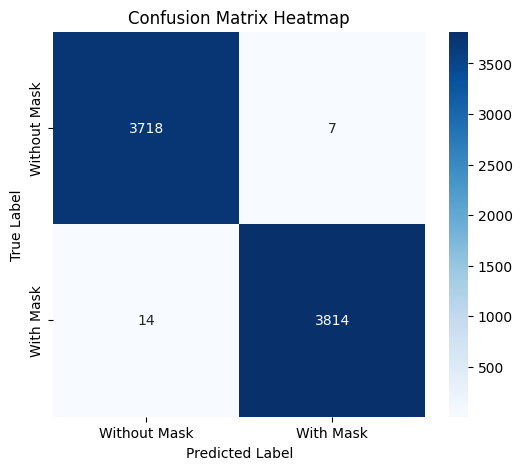

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Without Mask", "With Mask"], yticklabels=["Without Mask", "With Mask"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


 **Ana Gözlemler**  

Doğru Sınıflandırmalar:


*   Gerçek Pozitifler (TP) = 3814 → "Maske Takılı" doğru sınıflandırıldı.
*   Gerçek Negatifler (TN) = 3718 → "Maske Takılı Değil" doğru sınıflandırıldı.

Yanlış Sınıflandırmalar:


*   Yanlış Pozitifler (FP) = 7 → "Maske Takılı Değil" yanlışlıkla "Maske Takılı" olarak tahmin edildi.
*   Yanlış Negatifler (FN) = 14 → "Maske Takılı" yanlışlıkla "Maske Takılı Değil" olarak tahmin edildi.

Performans Analizi (Performance Insights):


*   Son derece yüksek doğruluk → Tahminlerin büyük çoğunluğu doğru.
*   Çok düşük yanlış sınıflandırma oranı:

 *   Sadece 7 yanlış pozitif (%0.09 hata).
 *   Sadece 14 yanlış negatif (%0.18 hata).  


*   Dengeli sınıflandırma → Model, her iki sınıfta da yüksek performans gösteriyor.

Sonuç:

*   Model, yüz maskelerini neredeyse mükemmel doğrulukla sınıflandırıyor.





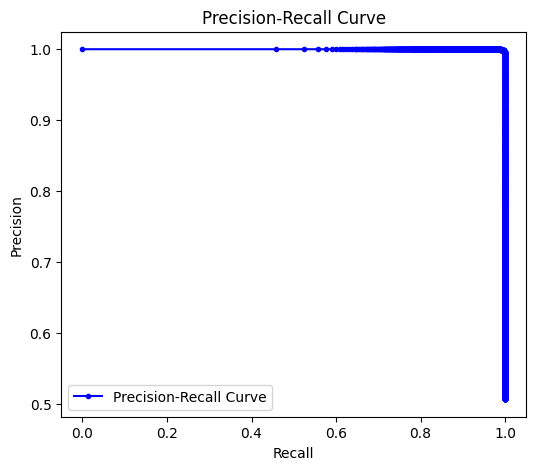

In [ ]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 1])

# Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


**Ana Gözlemler**


*   Eğri (ROC/AUC) (1,1) noktasına yakın kalıyor → Bu, modelin neredeyse tüm karar eşiklerinde hassasiyet (precision) ve duyarlılık (recall) değerlerini mükemmele yakın tuttuğunu gösterir.
*   Hassasiyet = 1.0 → Model çok az yanlış pozitif tahmin yapıyor.

*  Duyarlılık = 1.0 → Model neredeyse hiç yanlış negatif üretmiyor.
*  Recall = 1.0’a yaklaştığında hafif bir hassasiyet düşüşü görülüyor → Model, tüm pozitifleri yakalamaya çalışırken hassasiyette küçük bir düşüş yaşasa da, bu önemli değil.  

Sonuç:


*   Gerçek dünya uygulamaları için mükemmel performans gösteriyor.
*   Yanlış maskesiz tespitlerini en aza indirmek için yüksek hassasiyet gerektiren senaryolar için ideal.


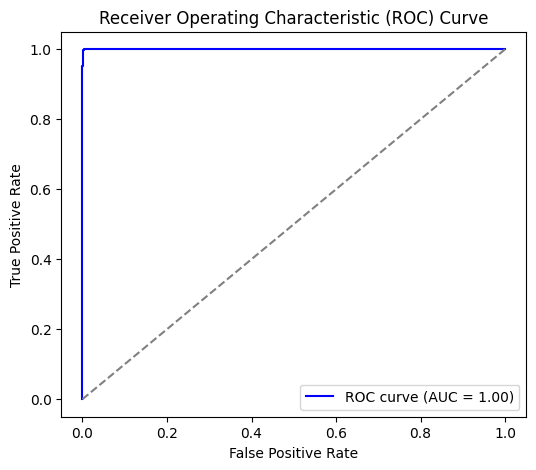

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


**Ana Gözlemler**


*   ROC Eğrisi sol üst köşeye (0,1) ulaşıyor → Bu, modelin mükemmel sınıflandırma yaptığını gösterir.
*   AUC (Eğri Altındaki Alan) = 1.00 → Bu, ulaşılabilecek en yüksek skordur ve modelin sınıfları hatasız ayırt ettiğini gösterir.

*   Yanlış Pozitif Oranı (FPR) ≈ 0 → Model, "Maske Takılı Değil" görüntülerini neredeyse hiç "Maske Takılı" olarak yanlış sınıflandırmıyor.
*   AUC = 1.00 → Mükemmel sınıflandırıcı (ideal durum).


*   Gerçek Pozitif Oranı (Duyarlılık) = 1.00 → Model, tüm "Maske Takılı" vakalarını doğru yakalıyor.
*   Yanlış Pozitif Oranı ≈ 0 → Model, yanlış "Maske Takılı" tahminleri

Sonuç:


*   Model, gerçek dünya yüz maskesi algılama uygulamaları için son derece sağlam ve güvenilirdir.
*   Herhangi bir önyargı veya sınıf dengesizliği sorunu bulunmamaktadır.


*   Düşük yanlış pozitif oranı sayesinde, halk güvenliği uygulamalarında kullanım için idealdir.


In [ ]:
model.save("face_mask_model_100epochs.h5")
print("Model saved successfully!")


Model saved successfully!
